In [13]:
import pytest
import dataclasses
import itertools
from typing import Any
import jax 

import equinox as eqx
import jax.numpy as jnp
import numpy as np
import seaborn as sns
from tqdm.auto import tqdm
import ultraplot as uplt
import optax
from rich.pretty import pprint
from jaxtyping import PyTree

from dataclasses import dataclass

from squint.circuit import Circuit, compile_experimental
from squint.diagram import draw
from squint.ops.fock import (
    BeamSplitter,
    FixedEnergyFockState,
    FockState,
    TwoModeWeakThermalState,
    Phase,
)
from squint.simulator import Simulator
from squint.ops.noise import ErasureChannel
from squint.utils import partition_op

## Direct detection setup

In [38]:
def direct_detection():
    dim = 2

    wire_star_left = "sl"
    wire_star_right = "sr"
    wire_dump_left = "dl"
    wire_dump_right = "dr"

    circuit = Circuit(backend="mixed")
    circuit.add(
        FockState(wires=(wire_star_left, wire_star_right), n=((1.0, (1,0)), (1.0, (0, 1)))),
        'star'
    )
    circuit.add(
        Phase(wires=(wire_star_left,), phi=0.1),
        'phase'
    )

    # loss modes
    for i, wire_dump in enumerate((wire_dump_left, wire_dump_right)):
        circuit.add(FockState(wires=(wire_dump,), n=(0,)), f"vac{i}")

    # loss beamsplitters
    for i, (wire_star, wire_dump) in enumerate(
        zip(
            (wire_star_left, wire_star_right),
            (wire_dump_left, wire_dump_right),
            strict=False,
        )
    ):
        circuit.add(BeamSplitter(wires=(wire_star, wire_dump), r=0.0), f"loss{i}")

    for i, wire_dump in enumerate((wire_dump_left, wire_dump_right)):
        circuit.add(ErasureChannel(wires=(wire_dump,)), f"ptrace{i}")

    circuit.add(
        BeamSplitter(wires=(wire_star_left, wire_star_right), r=jnp.pi/4), f"u"
    )

    return circuit, dim

## GJC scheme

In [39]:
def gjc_detection():
    dim = 3
    wires_star = ("s0", "s1")
    wires_ancilla = ("a0", "a1")
    wires_dump = ("d0", "d1")

    circuit = Circuit(backend="mixed")
    circuit.add(
        FockState(wires=wires_star, n=((1.0, (1,0)), (1.0, (0, 1)))),
        'star'
    )
    circuit.add(
        Phase(wires=(wires_star[0],), phi=0.1),
        'phase'
    )

    # ancilla modes
    circuit.add(
        FockState(
            wires=wires_ancilla,
            n=[
                (1.0, tuple(1 if i == j else 0 for i in wires_ancilla))
                for j in wires_ancilla
            ],
        ),
        "ancilla",
    )

    # loss modes
    for i, wire_dump in enumerate(wires_dump):
        circuit.add(FockState(wires=(wire_dump,), n=(0,)), f"vac{i}")

    for i in range(2):
        circuit.add(
            BeamSplitter(wires=(wires_ancilla[i], wires_dump[i]), r=0.0), f"loss{i}"
        )

    for i, (wire_ancilla, wire_star) in enumerate(
        zip(wires_ancilla, wires_star, strict=False)
    ):
        circuit.add(BeamSplitter(wires=(wire_ancilla, wire_star)), f"u{i}")

    for i, wire_dump in enumerate(wires_dump):
        circuit.add(ErasureChannel(wires=(wire_dump,)), f"ptrace{i}")

    return circuit, dim
    

In [64]:
@dataclass
class TelescopeScheme:
    circuit: Circuit = None
    sim: Simulator = None
    params_est: PyTree = None
    params_opt: PyTree = None
    params_fix: PyTree = None
    static: PyTree = None
    dim: int = None
    name: str = None
    
direct = TelescopeScheme(name="Direct")
gjc = TelescopeScheme(name="GJC")

In [65]:
direct.circuit, direct.dim = direct_detection()
gjc.circuit, gjc.dim = gjc_detection()

In [66]:
pprint(direct.circuit)
pprint(gjc.circuit)

Circuit(
  dims=None,
  ops={
│   'star':
│   FockState(
│     wires=('sl', 'sr'),
│     n=[(0.7071067811865475, (1, 0)), (0.7071067811865475, (0, 1))]
│   ),
│   'phase':
│   Phase(wires=('sl',), phi=weak_f64[]),
│   'vac0':
│   FockState(wires=('dl',), n=[(1.0, (0,))]),
│   'vac1':
│   FockState(wires=('dr',), n=[(1.0, (0,))]),
│   'loss0':
│   BeamSplitter(wires=('sl', 'dl'), r=weak_f64[]),
│   'loss1':
│   BeamSplitter(wires=('sr', 'dr'), r=weak_f64[]),
│   'ptrace0':
│   ErasureChannel(wires=('dl',)),
│   'ptrace1':
│   ErasureChannel(wires=('dr',)),
│   'u':
│   BeamSplitter(wires=('sl', 'sr'), r=weak_f64[])
  },
  _backend='mixed'
)

Circuit(
  dims=None,
  ops={
│   'star':
│   FockState(
│     wires=('s0', 's1'),
│     n=[(0.7071067811865475, (1, 0)), (0.7071067811865475, (0, 1))]
│   ),
│   'phase':
│   Phase(wires=('s0',), phi=weak_f64[]),
│   'ancilla':
│   FockState(
│     wires=('a0', 'a1'),
│     n=[(0.7071067811865475, (1, 0)), (0.7071067811865475, (0, 1))]
│   ),
│   'vac0':
│   FockState(wires=('d0',), n=[(1.0, (0,))]),
│   'vac1':
│   FockState(wires=('d1',), n=[(1.0, (0,))]),
│   'loss0':
│   BeamSplitter(wires=('a0', 'd0'), r=weak_f64[]),
│   'loss1':
│   BeamSplitter(wires=('a1', 'd1'), r=weak_f64[]),
│   'u0':
│   BeamSplitter(wires=('a0', 's0'), r=weak_f64[]),
│   'u1':
│   BeamSplitter(wires=('a1', 's1'), r=weak_f64[]),
│   'ptrace0':
│   ErasureChannel(wires=('d0',)),
│   'ptrace1':
│   ErasureChannel(wires=('d1',))
  },
  _backend='mixed'
)

In [67]:
# make all the direct detection scheme parameter pytrees
_params, direct.static = eqx.partition(direct.circuit, eqx.is_inexact_array)
direct.params_est, _params = partition_op(_params, "phase")    
direct.params_fix, direct.params_opt = eqx.partition(
    _params, 
    lambda x: any(x is leaf for leaf in [direct.circuit.ops['loss0'].r, direct.circuit.ops['loss1'].r])
)

# make all the GJC detection scheme parameter pytrees
_params, gjc.static = eqx.partition(gjc.circuit, eqx.is_inexact_array)
gjc.params_est, _params = partition_op(_params, "phase")    
gjc.params_fix, gjc.params_opt = eqx.partition(
    _params, 
    lambda x: any(x is leaf for leaf in [gjc.circuit.ops['loss0'].r, gjc.circuit.ops['loss1'].r])
)

Classical Fisher Information for direct scheme is:  0.9999999999999793
Classical Fisher Information for GJC scheme is:  0.49999999999201333


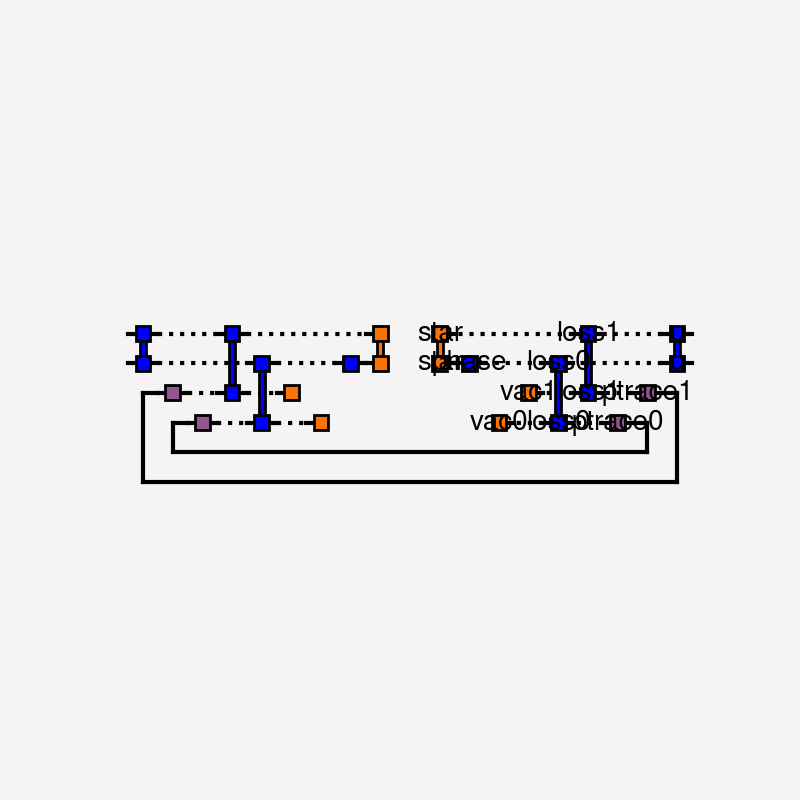

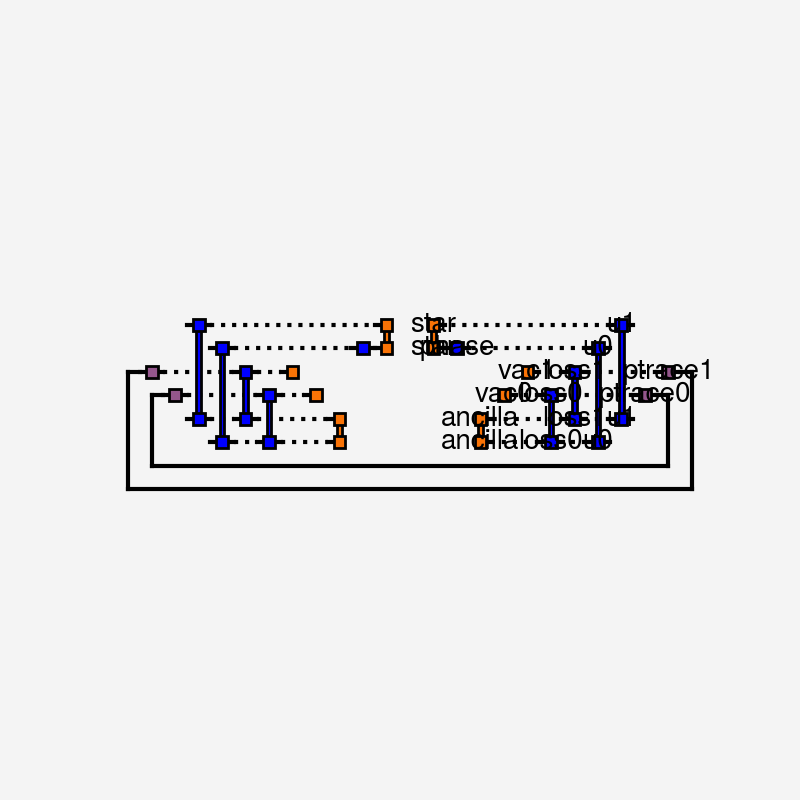

In [68]:
direct.sim = compile_experimental(
    direct.static, direct.dim, direct.params_est, direct.params_opt, direct.params_fix, **{"optimize": "greedy", "argnum": 0}
)
gjc.sim = compile_experimental(
    gjc.static, gjc.dim, gjc.params_est, gjc.params_opt, gjc.params_fix, **{"optimize": "greedy", "argnum": 0}
)

print(f"Classical Fisher Information for direct scheme is: ", direct.sim.probabilities.cfim(direct.params_est, direct.params_opt, direct.params_fix).squeeze())
print(f"Classical Fisher Information for GJC scheme is: ", gjc.sim.probabilities.cfim(gjc.params_est, gjc.params_opt, gjc.params_fix).squeeze())

draw(direct.circuit)
draw(gjc.circuit);

In [69]:
for scheme in (direct, gjc):
    rs = jnp.linspace(0.0, 1.0, 100)

    params_fix_vmap = eqx.tree_at(
        lambda pytree: [pytree.ops["loss0"].r, pytree.ops["loss1"].r], 
        scheme.params_fix, 
        [jnp.asin(rs), jnp.asin(rs)]
    )

    scheme.probs = jax.vmap(scheme.sim.probabilities.forward, in_axes=(None, None, 0))(scheme.params_est, scheme.params_opt, params_fix_vmap)
    scheme.cfims = jax.vmap(scheme.sim.probabilities.cfim, in_axes=(None, None, 0))(scheme.params_est, scheme.params_opt, params_fix_vmap)

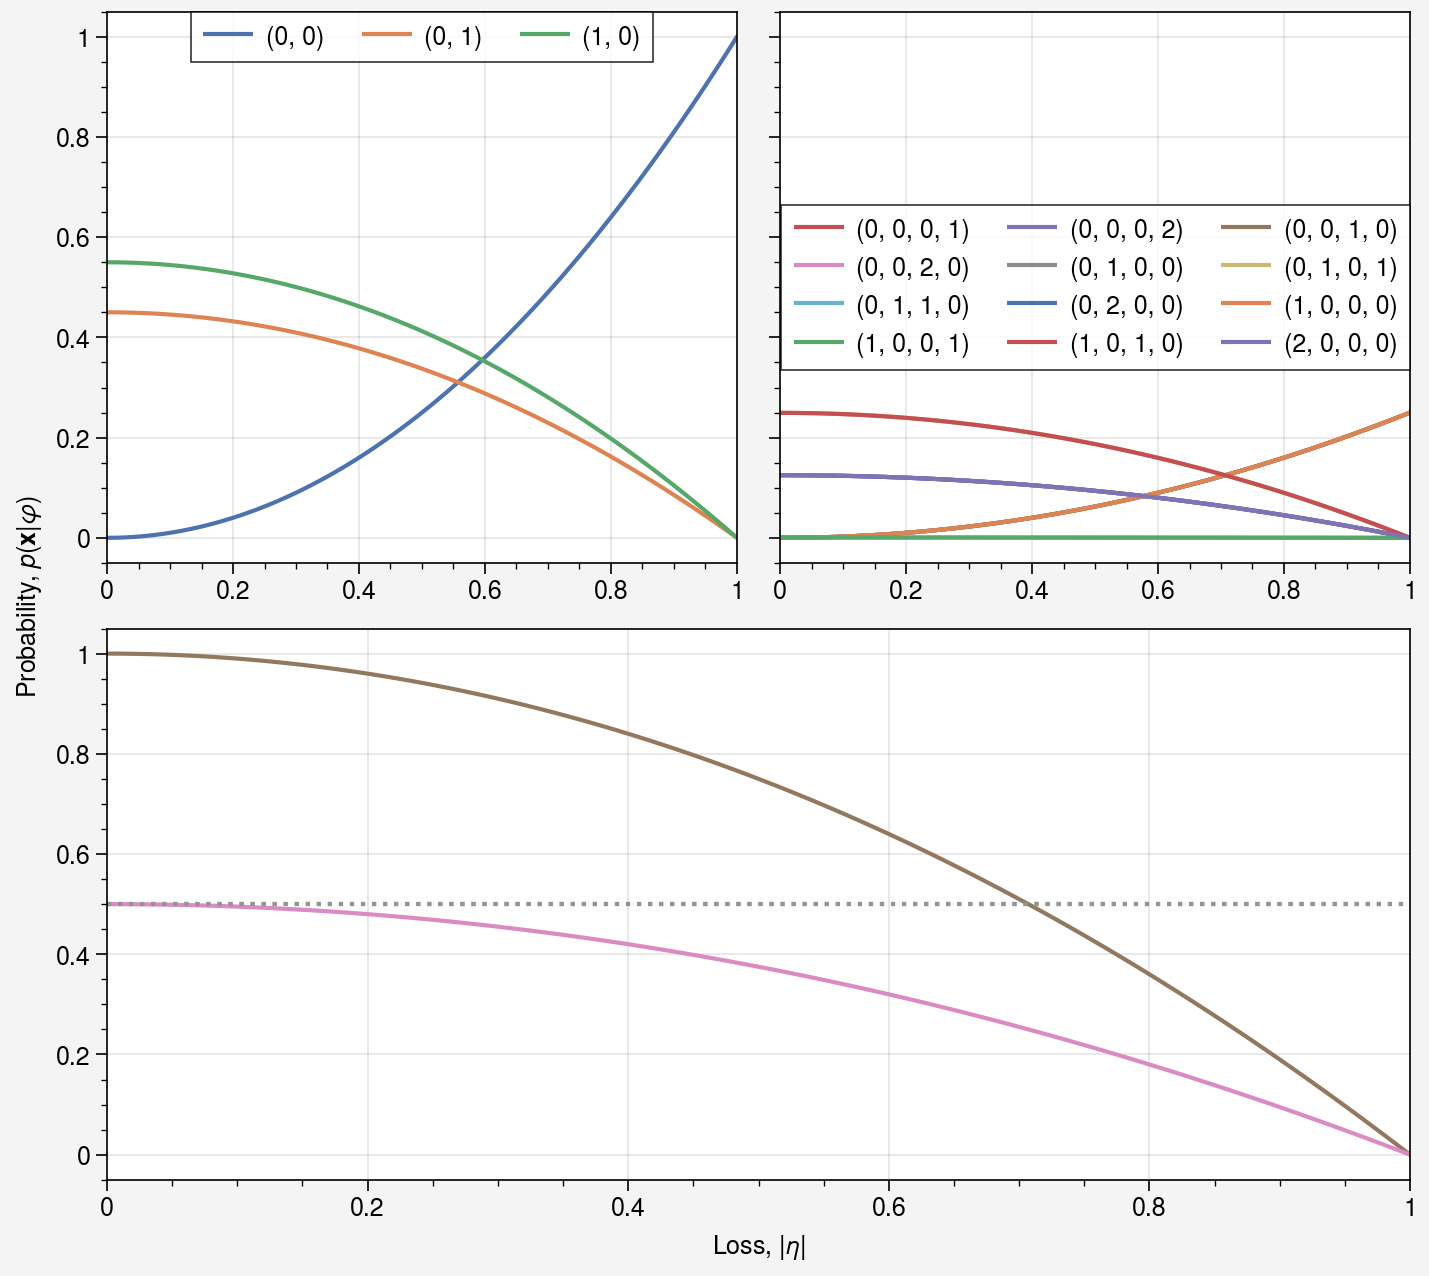

In [71]:
colors = itertools.cycle(sns.color_palette("deep", n_colors=10))
fig, axs = uplt.subplots(np.array([[1, 2],[3, 3]]), refwidth="8cm", refheight="7cm", sharey=True)

for k, scheme in enumerate((direct, gjc)):
    for i, idx in enumerate(
        itertools.product(*[list(range(ell)) for ell in scheme.probs.shape[1:]])
    ):
        if scheme.probs[:, *idx].mean() < 1e-6:
            continue
        axs[k].plot(rs, scheme.probs[:, *idx], label=f"{idx}", color=next(colors))
    axs[k].legend()
    axs[k].set(
        ylabel=r"Probability, $p(\mathbf{x} | \varphi)$"
    )
    
for k, scheme in enumerate((direct, gjc)):
    axs[2].plot(rs, scheme.cfims.squeeze(), color=next(colors), label=f"{scheme.name}")
    axs[2].axhline(0.5, ls=":", color="grey")
    axs[2].set(
        xlabel=r"Loss, $|\eta|$",
        ylabel=r"Classical Fisher Information, $\mathcal{I}_\varphi^C$",
        # ylim=[0, 1.05 * jnp.max(scheme.cfims)],
    );